<a href="https://colab.research.google.com/github/satadrudas98/Design_Optimization_Using_Ising_Machine/blob/main/Ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys


N = 3           # Number of spins
N_iters = 30   # Number of iterations per run
N_runs = 10     # Number of runs 

max_alpha = 2.0
min_alpha = 0.5
alpha_step = 0.1
plot_alpha = 1.5

max_beta = 2.0
min_beta = 0.1
beta_step = 0.1
plot_beta = (max_beta + min_beta)/2

sig = 0.04          # Std Deviation of noise
offset = 0.5    
V_pi = 1.0          # V_pi of the modulator
I0 = 1.0            # Action of photodiode and MZM
DC_bias = V_pi/4    # Action of DC_bias

scaling = 1.0

J_file = 0          #Flags which enable and disable different features
bifurcation = 0 
trajectory = 0
legend = 0
solver = 0
data_file = 0
tanh_switch = 1

In [ ]:
#print("sys.argv is :",sys.argv)
if(len(sys.argv)>1):
    i = 1
    while(i <= len(sys.argv[1:])):
        opt = str(sys.argv[i])
        #print(opt)

        #Alpha parameters
        if(opt == '-aplt'):
            plot_alpha = float(sys.argv[i+1])
        elif(opt == '-ua'):
            max_alpha = float(sys.argv[i+1])
        elif(opt == '-da'):
            min_alpha = float(sys.argv[i+1])
        elif(opt == '-sa'):
            alpha_step = float(sys.argv[i+1])
        elif(opt == '-a'):
            min_alpha = float(sys.argv[i+1])
            max_alpha = min_alpha + 1e-10
            plot_alpha = min_alpha
        
        #Beta parameters
        elif(opt == '-bplt'):
            plot_beta = float(sys.argv[i+1])
        elif(opt == '-ub'):
            max_beta = float(sys.argv[i+1])
        elif(opt == '-db'):
            min_beta = float(sys.argv[i+1])
        elif(opt == '-sb'):
            beta_step = float(sys.argv[i+1])
        elif(opt == '-b'):
            min_beta = float(sys.argv[i+1])
            max_beta = min_beta + 1e-10
            plot_beta = min_beta

       #Run parameters
        elif(opt == '-iter'):
            N_iters = int(sys.argv[i+1])
        elif(opt == '-N'):
            N = int(sys.argv[i+1])
        elif(opt == '-run'):
            N_runs = int(sys.argv[i+1])

        #Modulator parameters
        elif(opt == '-dc'):
            DC_bias = float(sys.argv[i+1])
        elif(opt == '-o'):
            offset = float(sys.argv[i+1])
        elif(opt == '-I'):
            I0 = float(sys.argv[i+1])
        elif(opt == '-pi'):
            V_pi = float(sys.argv[i+1])

        #Scaling parameters
        elif(opt == "-scaling"):
            scaling = float(sys.argv[i+1])
        
        #Noise parameters
        elif(opt == '-sig'):
            sig = float(sys.argv[i+1])
        
        #Config parameters        
        elif(opt == '-J'):
            J_file = str(sys.argv[i+1])
        elif(opt == '-sol'):
            solver = 1
        elif(opt == '-traj'):
            trajectory = 1
        elif(opt == '-legend'):
            legend = 1
        elif(opt == '-bif'):
            bifurcation = 1
        elif(opt == '-data'):
            data_file = str(sys.argv[i+1])
        elif(opt == '-notanh'):
            tanh_switch = 0
        i+=1


In [ ]:
J_file= "/content/s_100.txt"
N=100 
N_iter= 30 
N_runs =2
sig= 0.04 
max_alpha= 3.0 
min_alpha= 0.1 
alpha_step= 0.1 
max_beta= 3.0 
min_beta= 0.1
beta_step= 0.1 
trajectory = 1
bifurcation = 1
solver = 1
maxcut=180

In [ ]:
def modulator(x):
    return I0*pow(np.cos(x/V_pi + DC_bias*np.pi/(V_pi)),2) #Check this equation later

def feedback(x,alpha,beta,J):
    J = beta*J
    np.fill_diagonal(J,-alpha)
    return (J)@x

def notanh(x):
    for i,val in enumerate(x):
        if(val>=1):
            x[i] = 1
        elif(val<=-1):
            x[i] = -1
    return x        
    #return np.array([1 if i>=1 else -1 if i<=-1 else i for i in x])

def cut_value(cut):
    value = 0
    for row,i in enumerate(cut):
        for col,j in enumerate(cut):
            if(i*j<0):
                #print(i,j)
                #print("Row and column",row,col,J[row][col])
                value = value + J[row][col]
    return value/2



In [ ]:
#Initialize J to a ring if there is no input
J = np.zeros([N,N])
for i in range(1,N-1):
    J[i][i+1] = 1
    J[i][i-1] = 1

if(N >= 2):
    J[0][1] = 1
    J[0][N-1] = 1
    J[N-1][N-2] = 1
    J[N-1][0] = 1

#Load J from a file
if(J_file):
    f = open(J_file,"r")
    N, number_of_edges = [int(i) for i in f.readline().split()]
    J = np.zeros([N,N])
    lines = f.readlines()
    for line in lines:
        l = line.split()
        r,c,w = int(l[0])-1, int(l[1])-1, float(l[2])
        J[r][c] = w
        J[c][r] = w        
    f.close()
    print(J)


[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


Plot alpha = 1.5
Alpha = 1.5000000000000002
Plot Beta = 1.05
Beta = 1.0



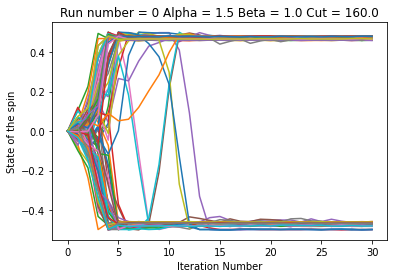

In [ ]:
#Create Alpha and Beta arrays
Alpha = np.arange(min_alpha,max_alpha,alpha_step)
Beta = np.arange(min_beta,max_beta,beta_step)
switch = 0
final_x = np.zeros([N,1])
pre_final_x = np.zeros([N,1])
traj_x = np.zeros([N,1])

solutions = []
for alpha in Alpha:
    for beta in Beta:
        for run in range(N_runs-1):
            x_k = np.zeros([N,1])
            x_in = np.zeros([N,1])
            #print("Working with Alpha = {}, Beta = {}, Run = {}".format(alpha,beta,run))
            i = 0
            traj_x = x_in
            noise = np.random.normal(0,sig,[N,N_iters])
            while(i < N_iters):
                # This is the calculated value to be put out to the DAC
                # Put the coupled equation instead later
                x_out = 2*np.around((feedback(x_k, alpha,beta,J) + np.array([noise[:,i]]).T)/2,3)
                #print((x_out.T).shape)
                #print(type(x_out))
                #print("notanh(x_out)",notanh(x_out))
                # The value received from the modulator
                if(tanh_switch):
                    x_in = 2*np.around(modulator(np.tanh(x_out))/2,3)
                else:
                    x_in = 2*np.around(modulator(notanh(x_out))/2,3)

                # print(x_in)
                # The state value
                x_k = (V_pi)*((1/I0)*x_in-offset)

                # print("x_k = ",x_k)
                i += 1
                # Add to trajectory
                traj_x = np.c_[traj_x,x_k]
            
            if(abs(np.around(alpha,3) - plot_alpha)<alpha_step and switch == 0 and abs(np.around(beta,3) - plot_beta)<beta_step):
                # plot trajectory   
                print("Plot alpha = {}\nAlpha = {}\nPlot Beta = {}\nBeta = {}\n".format(plot_alpha,alpha,plot_beta,beta))
                switch = 1
                if(trajectory):
                    plot1 = plt.figure(1)
                    for i in range(N):
                        plt.plot(traj_x[i],"-",label = "spin {}".format(i))
                    if(legend):
                        plt.legend()       
                    plt.title("Run number = {} Alpha = {} Beta = {} Cut = {}".format(run,np.around(alpha,3),np.around(beta,3),cut_value(np.sign(traj_x[:,-1]))))
                    plt.xlabel("Iteration Number")
                    plt.ylabel("State of the spin")
        
            pre_final_x = np.c_[pre_final_x,traj_x[:,-2]]
            final_x = np.c_[final_x,traj_x[:,-1]]
            cut = np.sign(traj_x[:,-1])
            #print(cut.shape)
            #print(cut_value(cut))
            #print(pre_final_x.shape,final_x.shape,cut.shape)
            if(solver):
                solutions.append([alpha,beta,run,cut_value(cut),cut,traj_x])








                #use the data in solution to plot


In [ ]:
fig_cut=[]
for i in range(len(solutions)):
  fig_cut.append(solutions[i][3])

In [ ]:
len(fig_cut)

841

In [ ]:
fig_cut=np.expand_dims(np.array(fig_cut), axis=-1)
fig_cut=fig_cut.T
np.shape(fig_cut)

(1, 841)

In [ ]:
fig_cut=fig_cut.reshape(len(Alpha),len(Beta))
fig_cut

In [ ]:
fig_cut=np.flip(fig_cut, axis=0)

In [ ]:
np.shape(fig_cut)

(29, 29)

In [ ]:
Alpha=np.round(Alpha, decimals=2)
Beta=np.round(Beta, decimals=2)
np.shape(Beta)


(29,)

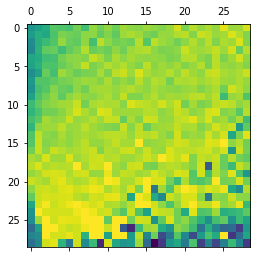

In [ ]:
plt.matshow(fig_cut)

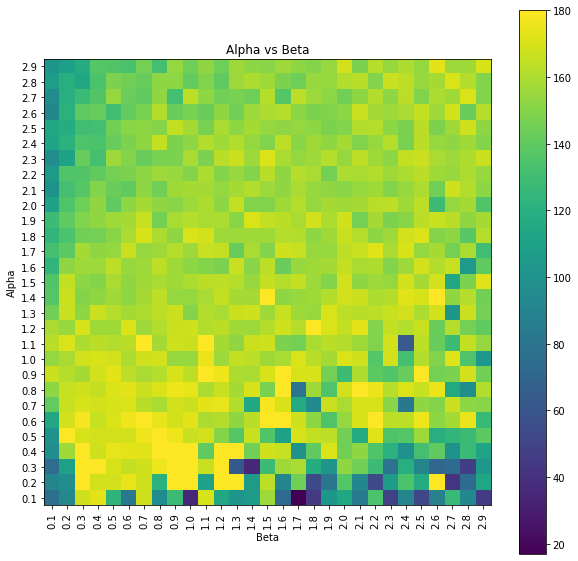

In [ ]:

fig, ax = plt.subplots(figsize=(10,10))
ax.set_yticks(np.arange(len(Alpha)-1,-1, -1))
ax.set_xticks(np.arange(0, len(Beta), 1), )
ax.set_xticklabels(Beta, rotation=90)
ax.set_yticklabels(Alpha,fontsize=10)
ax.set_title('Alpha vs Beta')
ax.set_xlabel("Beta")
ax.set_ylabel("Alpha")
im = ax.imshow(fig_cut)
cbar = fig.colorbar(im)


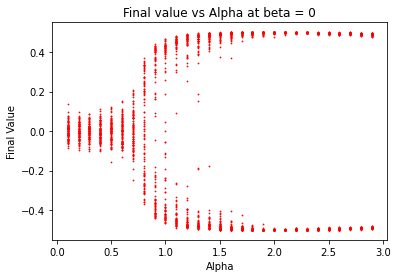

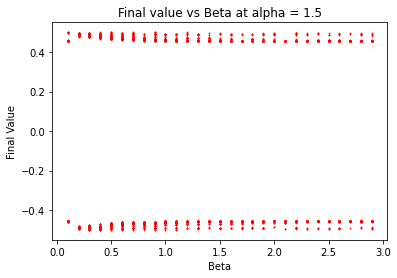

In [ ]:

if(bifurcation):# to plot bifurcation graph
    plot2 = plt.figure(2)
    index_alpha = np.where(abs(Beta-plot_beta)<beta_step)
    plt.plot(Alpha,final_x[:,1::(N_runs-1)*len(Beta)].T,"r.",markersize=1.5)#[:np.where(plot_beta<Beta)[0][0]]
    plt.title("Final value vs Alpha at beta = 0")
    plt.xlabel("Alpha")
    plt.ylabel("Final Value")
    # Include plot against beta here. Need to choose an alpha for this
    plot3 = plt.figure(3)
    try:
        index_alpha = np.where(abs(Alpha-plot_alpha)<alpha_step)[0][0]
    except:
        plt.show()
        exit(0)
    index_alpha *= N_runs*len(Beta)
    plt.plot(Beta,final_x[:, index_alpha:index_alpha+(N_runs-1)*len(Beta):N_runs-1].T,"r.",markersize=1.5)
    plt.title("Final value vs Beta at alpha = {}".format(plot_alpha))
    plt.xlabel("Beta")
    plt.ylabel("Final Value")
    # # plt.plot(Alpha,pre_final_x[:,1:].T,"r.",markersize=0.5)



The best cut value that was obtained is: 
Cut value: 180.0
Alpha: 0.2
Beta: 0.30000000000000004


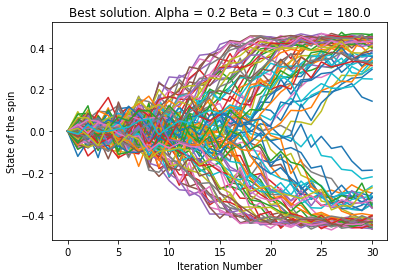

In [ ]:
if(solver):
    opt_cut_value = -1e10
    opt_alpha = 0
    opt_beta = 0
    opt_cut = np.zeros(N)
    for i in solutions:
        if (i[3] > opt_cut_value):
            opt_cut_value = i[3]
            opt_alpha = i[0]
            opt_beta = i[1]
            opt_cut = i[4]
            opt_traj = i[5]
    # print("The nodes on two sides of the cut are: ")
    # print("The negative side:")
    # for node,i in enumerate(opt_cut):
    #     if(i<0):
    #         print(node+1)
    # print("The positive side:")
    # for node,i in enumerate(opt_cut):
    #     if(i>0):
    #         print(node+1)
    # #print(cut)
    # print("The number of positive nodes is: ",len(np.where(opt_cut>0)[0]))
    # print("The number of negative nodes is: ",len(np.where(opt_cut<0)[0]))

    print("The best cut value that was obtained is: ")
    print("Cut value: {}\nAlpha: {}\nBeta: {}".format(opt_cut_value,opt_alpha,opt_beta))
    plot4 = plt.figure(4)
    for i in range(N):
        plt.plot(opt_traj[i],"-",label = "spin {}".format(i))
    if(legend):
        plt.legend()       
    plt.title("Best solution. Alpha = {} Beta = {} Cut = {}".format(np.around(opt_alpha,3),np.around(opt_beta,3),opt_cut_value))
    plt.xlabel("Iteration Number")
    plt.ylabel("State of the spin")


plt.show()

In [ ]:
def objective(alpha,beta):
 

  for run in range(N_runs-1):
    x_k = np.zeros([N,1])
    x_in = np.zeros([N,1])
    i = 0
    traj_x = x_in
    noise = np.random.normal(0,sig,[N,N_iters])
    while(i < N_iters):
      x_out = 2*np.around((feedback(x_k, alpha,beta,J) + np.array([noise[:,i]]).T)/2,3)
      if(tanh_switch):
        x_in = 2*np.around(modulator(np.tanh(x_out))/2,3)
      else:
        x_in = 2*np.around(modulator(notanh(x_out))/2,3)


      x_k = (V_pi)*((1/I0)*x_in-offset)
      i += 1
      traj_x = np.c_[traj_x,x_k]
      cut = np.sign(traj_x[:,-1])
      

  return cut_value(cut),traj_x




alpha=0.9381805778855383
beta=0.051855168552604414

cut,traj_x=objective(alpha,beta)
cut

627.0

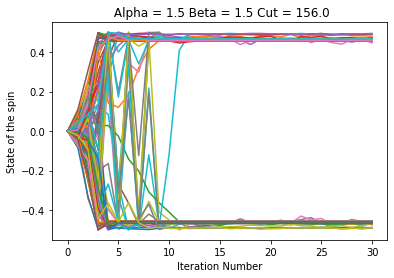

In [ ]:
plot1 = plt.figure()
for i in range(N):
  plt.plot(traj_x[i],"-",label = "spin {}".format(i))
  if(legend):
    plt.legend()       
  plt.title(" Alpha = {} Beta = {} Cut = {}".format(np.around(alpha,3),np.around(beta,3),cut_value(np.sign(traj_x[:,-1]))))
  plt.xlabel("Iteration Number")
  plt.ylabel("State of the spin")

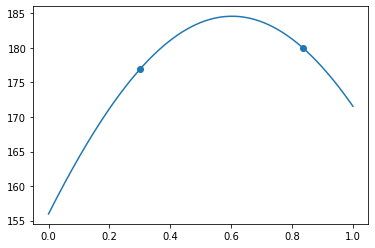

>x=0.483, f()=183.379031, actual=168.000
>x=0.095, f()=197.273158, actual=97.000
>x=0.974, f()=264.434152, actual=180.000
>x=0.836, f()=180.039199, actual=168.000
>x=0.684, f()=169.799583, actual=180.000
>x=0.701, f()=180.291283, actual=168.000
>x=0.613, f()=171.486900, actual=164.000
>x=0.978, f()=180.762299, actual=169.000
>x=0.136, f()=132.747871, actual=127.000
>x=0.307, f()=176.755371, actual=169.000


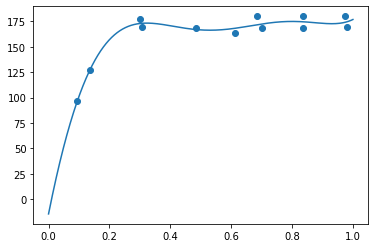

Best Result: x=0.835, y=180.000


In [ ]:
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

# objective function
def objective(alpha,beta):

  for run in range(N_runs-1):
    x_k = np.zeros([N,1])
    x_in = np.zeros([N,1])
    i = 0
    traj_x = x_in
    noise = np.random.normal(0,sig,[N,N_iters])
    while(i < N_iters):
      x_out = 2*np.around((feedback(x_k, alpha,beta,J) + np.array([noise[:,i]]).T)/2,3)
      if(tanh_switch):
        x_in = 2*np.around(modulator(np.tanh(x_out))/2,3)
      else:
        x_in = 2*np.around(modulator(notanh(x_out))/2,3)


      x_k = (V_pi)*((1/I0)*x_in-offset)
      i += 1
      traj_x = np.c_[traj_x,x_k]
      cut = np.sign(traj_x[:,-1])

  return cut_value(cut)

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True) #should take 2 inputs.

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(10)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()
 








X = random(2)
y = asarray([objective(0.5,x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)


# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)




# perform the optimization process
for i in range(10):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(0.5,x)
	# summarize the finding
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = vstack((X, [[x]]))
	y = vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

In [ ]:
pip install bayesian-optimization


  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=db64e11275adb924001838daaa79f4c0bcf5d2543a0eb0d61adba2a73175307f
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
 from bayes_opt import BayesianOptimization
import time

# Supress NaN warnings
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

# Bounded region of parameter space
pbounds = {'alpha': (0.0, 1.0),
           'beta': (0.0, 1.0)
          }

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1,
)

start_time = time.time()
optimizer.maximize(init_points=10, n_iter=10,)
time_took = time.time() - start_time


print(optimizer.max)

|   iter    |  target   |   alpha   |   beta    |
-------------------------------------------------
|  1        |  169.0    |  0.417    |  0.7203   |
|  2        |  0.0      |  0.000114 |  0.3023   |
|  3        |  82.0     |  0.1468   |  0.09234  |
|  4        |  180.0    |  0.1863   |  0.3456   |
|  5        |  171.0    |  0.3968   |  0.5388   |
|  6        |  174.0    |  0.4192   |  0.6852   |
|  7        |  147.0    |  0.2045   |  0.8781   |
|  8        |  136.0    |  0.02739  |  0.6705   |
|  9        |  170.0    |  0.4173   |  0.5587   |
|  10       |  91.0     |  0.1404   |  0.1981   |
|  11       |  180.0    |  0.3806   |  0.2929   |
|  12       |  169.0    |  0.7682   |  0.69     |
|  13       |  171.0    |  0.1493   |  0.6288   |
|  14       |  168.0    |  0.8475   |  0.3535   |
|  15       |  78.0     |  0.7883   |  0.00909  |
|  16       |  156.0    |  1.0      |  0.5677   |
|  17       |  158.0    |  0.9073   |  1.0      |
|  18       |  168.0    |  0.6153   |  0.9977   |


int